In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
from psis import psisloo

In [80]:
def plot_trend(x_axis, y_axis):
    plt.plot(x_axis, y_axis)
    plt.rcParams['figure.figsize'] = (10,5)
    z = np.polyfit(x_axis, y_axis, 1)
    trend = np.poly1d(z)
    plt.plot(x_axis, trend(x_axis), 'r--')
    plt.xticks(np.arange(2006, 2018, 1))
    plt.xlabel('year')
    plt.ylabel('deaths')
    plt.show()

## Total number of death due to road traffic accidents in Finland

[1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2]


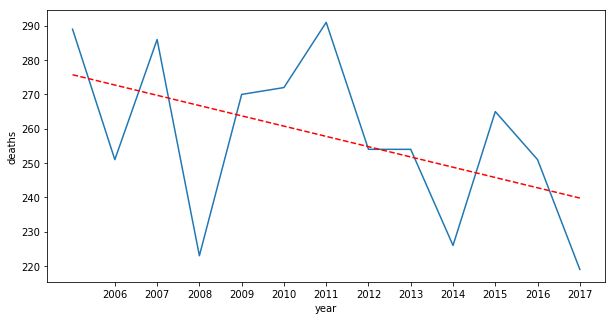

In [146]:
data = pd.read_csv('data/data.csv', sep = ',')
data['total']= data.iloc[:, 1:3].sum(axis=1)

years = data['year'].values
male = data['male'].values
female = data['female'].values
total_deaths = data['total'].values
prediction_year = 2018

mu = np.mean(total_deaths)
sigma = np.var(total_deaths)

# new params
num_groups = 2
x = np.arange(1,3)
x = np.repeat(x, len(years))
N = len(total_deaths) * 2
combined = np.concatenate((male, female), axis=0)


plot_trend(years, total_deaths)

In [152]:
# SEPARATE MODEL
accidents_code = '''
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] number_of_deaths;
    }

    parameters {
        vector[K] mu;         // group means
        vector<lower=0>[K] sigma;
    }

    model {
      number_of_deaths ~ normal(mu[x], sigma[x]);
    }

    generated quantities {
        real ypred;
        vector[N] log_lik;

        ypred = normal_rng(mu[2], sigma[2]);

        for (i in 1:N)
            log_lik[i] = normal_lpdf(number_of_deaths[i] | mu[x[i]], sigma[x[i]]);
    }
'''

accidents_data = {
        'N': N,
        'year': years,
        'number_of_deaths': combined,
        'prediction_year': prediction_year,
        'mean_data': mu,
        'variance_data': sigma,
        'K': num_groups,
        'x': x
    }

sm = pystan.StanModel(model_code = accidents_code)
separate_fit = sm.sampling(data = accidents_data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3272358f756f929d266dd8b75fecd002 NOW.


In [153]:
summary = separate_fit.summary()
summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])

log_lik = separate_fit.extract(permuted=True)['log_lik']

loo, loos, ks = psisloo(log_lik)
print('PSIS-LOO value: {0}'.format(loo))

S = np.shape(log_lik)[0]
lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

p_loocv = lppd - loo
print('The effective number of parameters is: {0}'.format(p_loocv))

print('K-hat values: {0}'.format(ks))

summary

PSIS-LOO value: -106.75013530028914
The effective number of parameters is: 2.9249070717426946
K-hat values: [0.32880145 0.09495741 0.17114603 0.27565387 0.21153705 0.25786509
 0.18162831 0.09777873 0.10973876 0.49483791 0.07916462 0.25786509
 0.36780578 0.11460468 0.11297162 0.15831137 0.38332147 0.14439514
 0.09600971 0.22321704 0.15292339 0.11297162 0.16068248 0.11460468
 0.5710908  0.38332147]


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu[1],193.566656,0.091646,5.405997,182.878712,190.057208,193.664994,197.028153,204.291209,3479.576758,1.001272
mu[2],64.259785,0.058425,3.307392,57.570082,62.194556,64.301059,66.372111,70.799617,3204.642599,1.000019
sigma[1],18.775794,0.083008,4.446711,12.411703,15.704674,18.013402,20.985682,29.689204,2869.722738,0.999562
sigma[2],11.525260,0.048390,2.703919,7.566942,9.674183,11.018180,12.918957,17.958587,3122.345587,0.999686
ypred,64.154135,0.199984,12.236564,39.375046,56.393921,64.248498,71.811783,88.331876,3743.950230,0.999719
log_lik[1],-4.769820,0.006230,0.427413,-5.816544,-5.010080,-4.685922,-4.463601,-4.150457,4707.421349,1.000450
log_lik[2],-3.956581,0.004389,0.228756,-4.448347,-4.100986,-3.937513,-3.797256,-3.555787,2715.916024,0.999495
log_lik[3],-4.367256,0.004536,0.294594,-5.056069,-4.527877,-4.327185,-4.157259,-3.907511,4217.469039,1.000518
log_lik[4],-4.550435,0.005245,0.342657,-5.322925,-4.750016,-4.511792,-4.304442,-4.008156,4267.923728,0.999588
log_lik[5],-4.013558,0.004221,0.227118,-4.488541,-4.154755,-3.998484,-3.852073,-3.619546,2895.178536,0.999955


In [169]:
# POOLED MODEL
pooled_factory_code = '''
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] number_of_deaths;
    
    real mean_data;
    real variance_data;
}

parameters {
    real mu;             // prior mean
    real<lower=0> sigma;
    
    real alpha;
    real beta;
}

model {
    
    beta ~ normal(mean_data, variance_data);

    number_of_deaths ~ normal(mu, sigma);
}

generated quantities {
    real ypred;
    vector[N] log_lik;
    
    ypred = normal_rng(alpha + (beta * 2018), sigma);
    //ypred = normal_rng(mu, sigma);
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(number_of_deaths[i] | mu, sigma);
}
'''


accidents_data = {
        'N': N,
        'year': years,
        'number_of_deaths': combined,
        'prediction_year': prediction_year,
        'mean_data': mu,
        'variance_data': sigma,
        'K': num_groups,
        'x': x
    }


sm = pystan.StanModel(model_code = pooled_factory_code)
pooled_fit = sm.sampling(data = accidents_data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e2a706d2b1a60f9ad30f98085bca3053 NOW.


In [170]:
summary = pooled_fit.summary()
summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])

log_lik = pooled_fit.extract(permuted=True)['log_lik']

loo, loos, ks = psisloo(log_lik)
print('PSIS-LOO value: {0}'.format(loo))

S = np.shape(log_lik)[0]
lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

p_loocv = lppd - loo
print('The effective number of parameters is: {0}'.format(p_loocv))

print('K-hat values: {0}'.format(ks))

summary

PSIS-LOO value: -147.3295622597027
The effective number of parameters is: 0.9802848309994943
K-hat values: [ 0.04219562  0.03006738  0.05722424 -0.00878744  0.01260818  0.02004185
  0.04803676  0.03603857  0.02548317 -0.01482482  0.03276862  0.02004185
 -0.03887274  0.17575446  0.17241243  0.12268886  0.27668172  0.17165439
  0.15193799  0.09135636  0.20626257  0.17241243  0.21867899  0.17575446
  0.23355049  0.27668172]


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu,1.291591e+02,2.325083e-01,1.359569e+01,1.023622e+02,1.200860e+02,1.293330e+02,1.382581e+02,1.558095e+02,3419.208218,1.000588
sigma,7.046377e+01,1.756943e-01,1.041323e+01,5.362080e+01,6.321565e+01,6.922201e+01,7.657450e+01,9.332464e+01,3512.816414,0.999741
alpha,-3.527434e+18,3.775673e+18,6.473002e+18,-1.819701e+19,-6.402761e+18,-2.535604e+18,1.309493e+18,6.410433e+18,2.939157,2.856282
beta,2.582110e+02,8.835980e+00,5.572197e+02,-8.408846e+02,-1.070139e+02,2.676746e+02,6.230223e+02,1.370227e+03,3976.889378,1.000045
ypred,-3.527434e+18,3.775673e+18,6.473002e+18,-1.819701e+19,-6.402761e+18,-2.535604e+18,1.309493e+18,6.410433e+18,2.939157,2.856282
log_lik[1],-6.006842e+00,4.070374e-03,2.611645e-01,-6.593606e+00,-6.167406e+00,-5.978774e+00,-5.818445e+00,-5.576422e+00,4116.799982,1.000317
log_lik[2],-5.527055e+00,2.774896e-03,1.682521e-01,-5.886592e+00,-5.630788e+00,-5.515455e+00,-5.409598e+00,-5.230544e+00,3676.438756,1.000416
log_lik[3],-5.897927e+00,3.706932e-03,2.366838e-01,-6.430277e+00,-6.040565e+00,-5.872855e+00,-5.726544e+00,-5.505128e+00,4076.693905,1.000354
log_lik[4],-5.387069e+00,2.581646e-03,1.528260e-01,-5.712011e+00,-5.486060e+00,-5.377926e+00,-5.279345e+00,-5.107845e+00,3504.297526,1.000333
log_lik[5],-5.764693e+00,3.323730e-03,2.088413e-01,-6.230791e+00,-5.894338e+00,-5.743572e+00,-5.616084e+00,-5.408657e+00,3948.039100,1.000397


In [164]:
# HIERARCHICAL MODEL
hierarchical_factory_code = '''
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] number_of_deaths;
}

parameters {
    real mu0;             // prior mean
    real<lower=0> sigma0; // prior 
    
    vector[K] mu;         // group means
    real<lower=0> sigma;
}

model {
    mu ~ normal(mu0, sigma0);
    number_of_deaths ~ normal(mu[x], sigma);
}

generated quantities {
    real mu3;
    real ypred;
    vector[N] log_lik;
    
    mu3 = normal_rng(mu0, sigma0);
    ypred = normal_rng(mu[2], sigma);
    
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(number_of_deaths[i] | mu[x[i]], sigma);    
}
'''


accidents_data = {
        'N': N,
        'year': years,
        'number_of_deaths': combined,
        'prediction_year': prediction_year,
        'mean_data': mu,
        'variance_data': sigma,
        'K': num_groups,
        'x': x
    }


sm = pystan.StanModel(model_code = hierarchical_factory_code)
hierarchical_fit = sm.sampling(data = accidents_data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c4b648e9e9309fe2176fda48161fafe4 NOW.


In [165]:
summary = hierarchical_fit.summary()
summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])

log_lik = hierarchical_fit.extract(permuted=True)['log_lik']

loo, loos, ks = psisloo(log_lik)
print('PSIS-LOO value: {0}'.format(loo))

S = np.shape(log_lik)[0]
lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

p_loocv = lppd - loo
print('The effective number of parameters is: {0}'.format(p_loocv))

print('K-hat values: {0}'.format(ks))

summary

PSIS-LOO value: -107.25441951882813
The effective number of parameters is: 2.5216634985764728
K-hat values: [ 0.00840963  0.02300535  0.05266991  0.32393447 -0.01097478 -0.017516
  0.04863637  0.07184699  0.03678806  0.4563215   0.06890817 -0.017516
  0.36911502  0.02049945  0.02744453  0.1259673   0.17598525  0.07247911
  0.07141031  0.21369146  0.10451994  0.02744453  0.10962256  0.02049945
  0.29025607  0.17598525]


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu0,8.362804e+06,1.509622e+07,1.166573e+08,-9.760909e+07,-8.280941e+05,6.710579e+03,2.678104e+06,2.627165e+08,59.715533,1.078800
sigma0,3.240835e+08,9.607845e+07,2.777353e+09,1.210652e+04,3.646548e+05,4.053384e+06,5.094215e+07,1.871551e+09,835.622514,1.007450
mu[1],1.933227e+02,1.295081e-01,4.170009e+00,1.849818e+02,1.907234e+02,1.931519e+02,1.960888e+02,2.015668e+02,1036.764763,1.002787
mu[2],6.435724e+01,1.141250e-01,3.973076e+00,5.620089e+01,6.173542e+01,6.434755e+01,6.711158e+01,7.229673e+01,1211.970693,1.003056
sigma,1.466974e+01,7.168790e-02,2.313555e+00,1.098179e+01,1.307436e+01,1.434197e+01,1.593739e+01,1.984601e+01,1041.520992,1.004858
mu3,2.458257e+07,3.792513e+07,2.365418e+09,-5.811977e+08,-2.462573e+06,1.633856e+03,3.093147e+06,6.723655e+08,3890.109087,0.999399
ypred,6.404514e+01,2.693261e-01,1.524823e+01,3.404111e+01,5.397238e+01,6.411412e+01,7.413825e+01,9.404620e+01,3205.398937,1.000336
log_lik[1],-5.024414e+00,1.555775e-02,5.358410e-01,-6.273195e+00,-5.330612e+00,-4.961832e+00,-4.634858e+00,-4.180930e+00,1186.255565,1.001770
log_lik[2],-3.766357e+00,5.960215e-03,1.924814e-01,-4.195474e+00,-3.884456e+00,-3.748042e+00,-3.628742e+00,-3.437639e+00,1042.925949,1.001732
log_lik[3],-4.407746e+00,1.053038e-02,3.607164e-01,-5.265497e+00,-4.607154e+00,-4.374201e+00,-4.145644e+00,-3.825656e+00,1173.393122,1.002335


<h2>DON'T TOUCH</h2>

In [88]:
# POOLED MODEL
accidents_code = '''
data {
    int <lower=0> N;             //number of data points
    vector[N] year;              //observation year
    vector[N] number_of_deaths;  //total number of deaths
    real prediction_year;        //prediction year
    
    real mean_data;
    real variance_data;
}

parameters {
    real alpha;
    real beta;
    real <lower=0> sigma;
}

transformed parameters {
    vector[N] mu;
    mu = alpha + (beta * year);
}

model {
    beta ~ normal(mean_data, variance_data);
    number_of_deaths ~ normal(mu, sigma);
}

generated quantities {
    vector[N] log_lik;
    real ypred;
    ypred = normal_rng(alpha + (beta * prediction_year), sigma);
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(number_of_deaths[i] | mu, sigma);
}
'''
model = pystan.StanModel(model_code=accidents_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_08358f6ba04d909bf58b98a68905ca88 NOW.


In [92]:
def stan_sampling_fit(deaths, years, year_to_predict):
    accidents_data = {
        'N': len(deaths),
        'year': years,
        'number_of_deaths': deaths,
        'prediction_year': year_to_predict,
        'mean_data': mu,
        'variance_data': sigma
    }
    return model.sampling(data = accidents_data, control = {'adapt_delta': 0.95, 'max_treedepth': 15})

In [93]:
accidents_fit = stan_sampling_fit(total_deaths, years, prediction_year)
summary = accidents_fit.summary()
summary = pd.DataFrame(
    summary['summary'], 
    columns=summary['summary_colnames'], 
    index=summary['summary_rownames']
)

summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,6204.828726,150.933996,3761.079796,-1137.273917,3724.947572,6222.663028,8537.739640,14237.816559,620.941881,1.004204
beta,-2.957289,0.075047,1.870205,-6.955245,-4.119105,-2.964891,-1.724260,0.690482,621.034706,1.004210
sigma,25.449274,0.241566,7.059479,16.195590,20.625374,24.201249,28.630868,42.000526,854.029137,1.008622
mu[1],275.465008,0.471963,13.554274,248.692233,267.050012,275.396564,283.770678,302.426057,824.776184,1.001645
mu[2],272.507719,0.399084,12.037588,248.487374,265.145242,272.470661,279.857875,296.495408,909.810198,1.001219
mu[3],269.550431,0.327143,10.634097,248.192885,262.965213,269.536479,275.879999,290.363102,1056.640027,1.000711
mu[4],266.593142,0.256015,9.394672,247.859487,260.758148,266.592878,272.160597,285.135122,1346.579830,1.000154
mu[5],263.635853,0.191304,8.392320,247.023526,258.594832,263.626682,268.642885,280.284559,1924.491041,0.999662
mu[6],260.678565,0.143466,7.719944,244.866378,255.982864,260.710746,265.215716,276.036490,2895.527759,0.999464
mu[7],257.721276,0.125316,7.467220,242.738338,253.151080,257.707949,262.298796,272.478411,3550.618252,0.999806


In [94]:
log_lik = accidents_fit.extract(permuted=True)['log_lik']

loo, loos, ks = psisloo(log_lik)
print('PSIS-LOO value: {0}'.format(loo))

S = np.shape(log_lik)[0]
lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

p_loocv = lppd - loo
print('The effective number of parameters is: {0}'.format(p_loocv))

print('KS value: {0}'.format(ks))

PSIS-LOO value: -1073.7430435979738
The effective number of parameters is: 334.2322711627885
KS value: [4.66699334 2.24970016 3.98836063 5.17580993 1.82651468 1.75728701
 4.84117662 2.23982191 2.23982191 4.84245416 2.30440344 2.24970016
 6.18708349]


#### Predictions for total number of deaths in 2018

In [7]:
def plot_perdiction_histogram(fit, xlim, xticks):
    y_pred = fit.extract()['ypred']
    plt.hist(y_pred, bins=40, ec='white', alpha=0.7)
    plt.xlim(xlim[0], xlim[1])
    plt.xticks(xticks)
    plt.show()

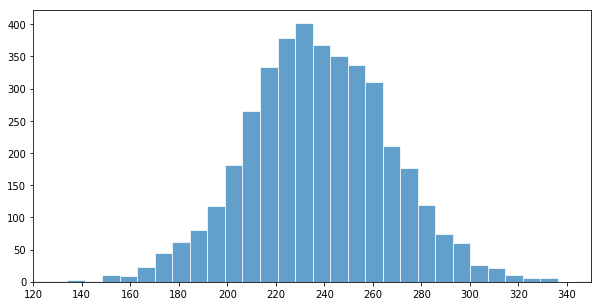

In [8]:
plot_perdiction_histogram(
    accidents_fit, 
    xlim=[120, 350], 
    xticks=np.arange(120, 360, 20)
)

## Male death due to road traffic accidents in Finland

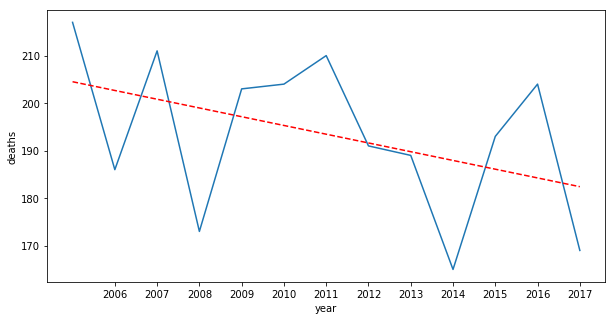

In [9]:
plot_trend(years, male)

In [10]:
accidents_fit_male = stan_sampling_fit(male, years, prediction_year)
summary_male = accidents_fit_male.summary()
summary_male = pd.DataFrame(
    summary_male['summary'], 
    columns=summary_male['summary_colnames'], 
    index=summary_male['summary_rownames']
)

summary_male

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,3736.250993,270.587926,2750.995897,-2110.994679,2116.401739,3788.758163,5460.833686,8887.710308,103.362512,1.044950
beta,-1.761662,0.134560,1.367923,-4.322608,-2.619405,-1.787750,-0.957213,1.149628,103.346098,1.044971
sigma,17.836704,0.211912,4.064771,11.854207,14.954784,17.091811,19.968009,27.758148,367.927314,1.007070
mu[1],204.118739,0.808310,9.650606,184.950055,197.913631,204.212390,210.144261,223.399120,142.545366,1.028463
mu[2],202.357077,0.675166,8.502010,185.545988,196.975906,202.365261,207.706002,219.428880,158.570587,1.024852
mu[3],200.595415,0.539695,7.428095,185.847088,195.857289,200.593110,205.297422,215.907152,189.433812,1.020144
mu[4],198.833753,0.402152,6.466177,185.815099,194.698426,198.838796,202.852596,212.221036,258.532851,1.014250
mu[5],197.072091,0.261737,5.673511,185.562534,193.401814,197.120813,200.622534,208.841488,469.864318,1.007713
mu[6],195.310429,0.125091,5.129175,184.925765,191.919096,195.401362,198.567787,205.752075,1681.292874,1.002506
mu[7],193.548767,0.081908,4.916358,183.737766,190.388573,193.547988,196.687796,203.299586,3602.733112,1.001858


#### Predictions for number of male deaths in 2018

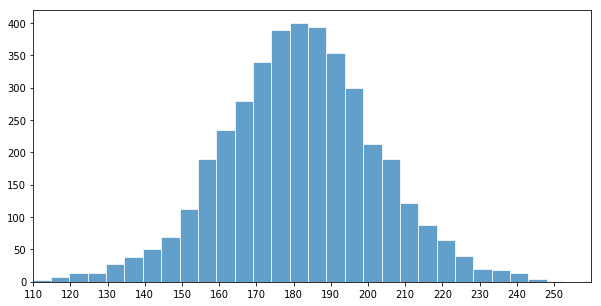

In [11]:
plot_perdiction_histogram(
    accidents_fit_male, 
    xlim=[110, 260], 
    xticks=np.arange(110, 260, 10)
)

## Female death due to road traffic accidents in Finland

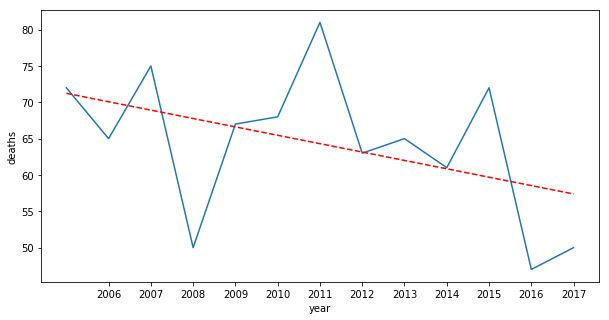

In [12]:
plot_trend(years, female)

In [13]:
accidents_fit_female = stan_sampling_fit(female, years, prediction_year)
summary_female = accidents_fit_female.summary()
summary_female = pd.DataFrame(
    summary_female['summary'], 
    columns=summary_female['summary_colnames'], 
    index=summary_female['summary_rownames']
)

summary_female

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,2369.248788,121.737375,1659.366637,-1089.514757,1329.222126,2362.730241,3410.785300,5631.628016,185.796206,1.040411
beta,-1.146139,0.060532,0.825172,-2.766537,-1.664266,-1.143387,-0.628378,0.573541,185.828958,1.040406
sigma,10.718313,0.182516,2.500732,7.212495,8.981616,10.273506,12.089514,17.055571,187.728615,1.031169
mu[1],71.240357,0.373633,5.744142,59.517981,67.750242,71.136040,74.879736,82.610444,236.352307,1.030057
mu[2],70.094218,0.313624,5.059485,59.728950,67.001327,69.991185,73.308051,80.194240,260.252455,1.026831
mu[3],68.948079,0.253844,4.423058,59.943728,66.276545,68.871593,71.761913,77.794675,303.607806,1.022365
mu[4],67.801941,0.194460,3.858796,60.109238,65.444816,67.694930,70.272976,75.488043,393.771817,1.016388
mu[5],66.655802,0.135742,3.402791,59.934296,64.567036,66.630162,68.822909,73.561486,628.412420,1.009172
mu[6],65.509663,0.079542,3.103141,59.318615,63.594122,65.467299,67.487240,71.799119,1521.997575,1.002420
mu[7],64.363524,0.047756,3.006958,58.303687,62.510099,64.353945,66.223512,70.485103,3964.571714,0.999319


### Predictions for number of female deaths in 2018

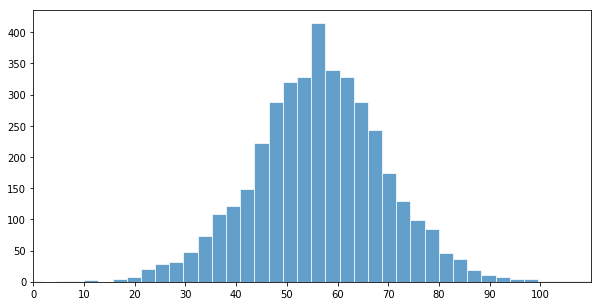

In [14]:
plot_perdiction_histogram(
    accidents_fit_female, 
    xlim=[0, 110], 
    xticks=np.arange(0, 110, 10)
)